In [22]:
import os
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pingouin as pg
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.base import clone
import warnings
from sklearn.exceptions import ConvergenceWarning

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# Main directory
MainDir = r""
# Directory with data
DataDir = os.path.join(MainDir,"eeg_features")
# File names
File_names = list(filter(lambda x: '.csv' in x, os.listdir(DataDir)))
# get feature names
Features = [feature.replace('.csv','') for feature in File_names]
# load file with full names of EEG features
eeg_names = pd.read_csv("eeg_features_names.csv", index_col = 0)

In [3]:
# lr model
# variance threshold normalizes and deletes variables with no variance
lrclass_model = Pipeline(steps = [('impute', SimpleImputer(missing_values = np.nan, strategy='median')),
                                  ('variance', VarianceThreshold()),
                                  ('normalize', StandardScaler()),
                                  ('lr', LogisticRegressionCV(Cs = np.logspace(-4,4,10), cv = 3, random_state=234))])

In [4]:
# repeat procedure 
repeat_n = 100
cv_i = 3
# define random split function
random_sp = RepeatedStratifiedKFold(n_splits = cv_i, n_repeats = repeat_n,random_state = 234)

# define random split function permutation
repeat_nn = 1000
random_sp_1000 = RepeatedStratifiedKFold(n_splits = cv_i, n_repeats = repeat_nn, random_state = 234)

In [5]:
# allocate memory
# train data
roc_scores_train = np.zeros((len(File_names), cv_i, repeat_n))
roc_scores_null_train = np.zeros((len(File_names), cv_i, repeat_nn))
# test data
roc_scores_test = np.zeros((len(File_names), cv_i, repeat_n))
roc_scores_null_test = np.zeros((len(File_names), cv_i, repeat_nn))
# train data
acc_scores_train = np.zeros((len(File_names), cv_i, repeat_n))
acc_scores_null_train = np.zeros((len(File_names), cv_i, repeat_nn))
# test data
acc_scores_test = np.zeros((len(File_names), cv_i, repeat_n))
acc_scores_null_test = np.zeros((len(File_names), cv_i, repeat_nn))

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    
    for k in tqdm(range(len(File_names))):
    
        inFile = File_names[k]
        dataX = pd.read_csv(DataDir + "\\" + inFile)
    
        group_cat = np.array(dataX['Group'])
        group_cat[group_cat == 'SZPatients'] = 1
        group_cat[group_cat == 'Controls'] = 0
        group_cat = group_cat.astype(int)
    
        eeg = dataX.drop(['Group'],axis = 1)
    
        c_s = 0
        rep = 0
        # get true estimate of acc and roc
        for train_index, test_index in random_sp.split(eeg, group_cat):
        
            eeg_train = eeg.values[train_index,:]
            eeg_test = eeg.values[test_index,:]
            group_train = group_cat[train_index]
            group_test = group_cat[test_index]
        
            # fit Ridge model
            internal_lr = clone(lrclass_model)
            fit_lr = internal_lr.fit(eeg_train,group_train)
        
            # predict data
            predict_train = fit_lr.predict(eeg_train)
            predict_test = fit_lr.predict(eeg_test)
        
            # save performance
            roc_scores_train[k,c_s,rep] = roc_auc_score(group_train, predict_train)
            roc_scores_test[k,c_s,rep] = roc_auc_score(group_test, predict_test)
            acc_scores_train[k,c_s,rep] = accuracy_score(group_train, predict_train)
            acc_scores_test[k,c_s,rep] = accuracy_score(group_test, predict_test)
            
            c_s = c_s + 1
        
            if c_s == cv_i:
                rep = rep + 1
                c_s = 0
        
        # create null models
            
        rep = 0
        c_s = 0
        
        for train_index_n, test_index_n in random_sp_1000.split(eeg, group_cat):
            
            # random label permutation
            np.random.seed(rep)
            perm_ix_tr = np.random.permutation(len(train_index_n))
            perm_ix_ts = np.random.permutation(len(test_index_n))
            
            
            eeg_train = eeg.values[train_index_n,:]
            eeg_test = eeg.values[test_index_n,:]
            group_train = group_cat[train_index_n[perm_ix_tr]]
            group_test = group_cat[test_index_n[perm_ix_ts]]
        
            # fit Ridge model
            internal_lr = clone(lrclass_model)
            fit_lr = internal_lr.fit(eeg_train,group_train)
        
            # predict data
            predict_train = fit_lr.predict(eeg_train)
            predict_test = fit_lr.predict(eeg_test)
        
            # save performance
            roc_scores_null_train[k,c_s,rep] = roc_auc_score(group_train, predict_train)
            roc_scores_null_test[k,c_s,rep] = roc_auc_score(group_test, predict_test)
            acc_scores_null_train[k,c_s,rep] = accuracy_score(group_train, predict_train)
            acc_scores_null_test[k,c_s,rep] = accuracy_score(group_test, predict_test)
            
            c_s = c_s + 1
        
            if c_s == cv_i:
                rep = rep + 1
                c_s = 0



100%|████████████████████████████████████████████████████████████████████████████| 194/194 [19:55:00<00:00, 369.59s/it]


In [6]:
roc_test = roc_scores_test.mean(axis=1).mean(axis=1)
roc_null = roc_scores_null_test.mean(axis=1)

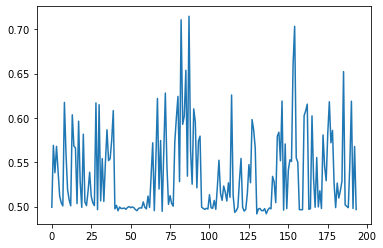

In [8]:
plt.plot(roc_test)

In [14]:
roc_test = roc_scores_test.mean(axis=1).mean(axis=1)
roc_null = roc_scores_null_test.mean(axis=1)
# acccuracies
acc_test = acc_scores_test.mean(axis=1).mean(axis=1)
acc_null = acc_scores_null_test.mean(axis=1)
# get p values from permutation
pvals_null = [len(np.where(roc_test[i] < roc_null[i])[0])/repeat_nn for i in range(len(roc_test))]
_, pvals_null_corr = pg.multicomp(pvals_null, alpha=0.05, method='fdr_bh') 

# load data frame from ancova analysis
ancova_results = pd.read_csv("CohenD_for_ANCOVAs.csv", index_col=0)
pvals_ancova = ancova_results.loc[Features]['p-vals']
len(np.where(np.array(pvals_null)<0.05)[0])

91

In [17]:
index_df = eeg_names.loc[Features]['new-names']
data_df = np.vstack((np.round(roc_scores_train.mean(axis=1).mean(axis=1),4),np.round(roc_scores_test.mean(axis=1).mean(axis=1),4), 
                     np.round(acc_scores_train.mean(axis=1).mean(axis=1),4),np.round(acc_scores_test.mean(axis=1).mean(axis=1),4),np.array(pvals_null),
                     np.array(pvals_ancova))).transpose()
columns_df = ['auc score train', 'auc score test', 'acc score train', 'acc score test', 'p-value', 'p-value group ancova']
df_classification = pd.DataFrame(data=data_df, index=index_df, columns=columns_df)
df_classification.to_csv("classification_results.csv")

In [18]:
out_features_null = np.array(Features)[np.where(np.array(pvals_null) < 0.05)[0]]
out_features_ancova = ancova_results.index[np.where(pvals_ancova < 0.05)[0]]
significant_in_ancova = [len(np.where(out_features_ancova[k] == out_features_null)[0]) for k in range(len(out_features_ancova))]

print(out_features_ancova[np.where(np.array(significant_in_ancova) == 0)[0]])
print(f'significant features classification: {len(out_features_null)}')
auc_train = df_classification.iloc[np.where(df_classification['p-value'] < 0.05)[0]]['auc score train'].min(), df_classification.iloc[np.where(df_classification['p-value'] < 0.05)[0]]['auc score train'].max()
auc_test = df_classification.iloc[np.where(df_classification['p-value'] < 0.05)[0]]['auc score test'].min(), df_classification.iloc[np.where(df_classification['p-value'] < 0.05)[0]]['auc score test'].max()
acc_train = df_classification.iloc[np.where(df_classification['p-value'] < 0.05)[0]]['acc score train'].min(), df_classification.iloc[np.where(df_classification['p-value'] < 0.05)[0]]['acc score train'].max()
acc_test = df_classification.iloc[np.where(df_classification['p-value'] < 0.05)[0]]['acc score test'].min(), df_classification.iloc[np.where(df_classification['p-value'] < 0.05)[0]]['acc score test'].max()

print(f'sign min max auc train: {auc_train}')
print(f'sign min max auc test: {auc_test}')
print(f'sign min max acc train: {acc_train}')
print(f'sign min max acc test: {acc_test}')

Index(['amp_env_meanGamma', 'amp_env_stdGamma', 'amp_skewTheta',
       'amp_total_powGamma', 'el_plv_betw_delta', 'el_plv_betw_gamma',
       'HFD_Delta', 'INSTalpha_nodestrength', 'INSTbeta_betwcentr',
       'INSTtheta_clusteringcoefficient', 'KFD_Gamma', 'LCOHgamma_betwcentr'],
      dtype='object')
significant features classification: 91
sign min max auc train: (0.6095, 0.8475)
sign min max auc test: (0.5233, 0.7147)
sign min max acc train: (0.6906, 0.8726)
sign min max acc test: (0.5903, 0.7358)


In [25]:
sum(significant_in_ancova)

57

In [23]:
# create data frame
# EEG feature, auc train, auc test, p-value null, acc train acc test

# save data in pickle
results_class = {"eeg features": File_names,
                 "roc_scores_train": roc_scores_train,
                 "roc_scores_test": roc_scores_test,
                 "acc_scores_train": acc_scores_train,
                 "acc_scores_test": acc_scores_test,
                 "roc_scores_null_train": roc_scores_null_train,
                 "roc_scores_null_test": roc_scores_null_train,
                 "acc_scores_null_train": roc_scores_null_train,
                 "acc_scores_null_test": roc_scores_null_train,
                 "pval": pvals_null}

with open('results_class.pkl', "wb") as f:
    pickle.dump(results_class, f)